# Logisztikus regresszió alkalmazása szöveg multiosztályozásra

## Feladat rövid leírása

A feladat során a books.json multiklasszifkációs adatbázis felhasználásával mutatom be a logisztikus regresszió alkalmazását amely segitségével a megfelelő adatisztási feladatok elvégzésvel 24.75%-os pontosságot sikerült elérnem.

## Készítette:
### Név: Hernádi Mihály
### Neptun kód: IP2CC3

## Adatok előkészítése

### Nyers adat beolvasása

In [1]:
import pandas as pd

df_books = pd.read_json("data/books.json", orient='records')
df_books.head(10)

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among t...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school b..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fian...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel returni...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben ...
5,5,Thendara House,fantasy,The novel concerns the dwelling of the Darkova...
6,6,The Thief,fantasy,"Gen is released from prison by the magus, the ..."
7,7,The Sweet Far Thing,fantasy,The prologue begins with two men who are searc...
8,8,Mistborn: The Final Empire,fantasy,"In Luthadel, the capital city of the Final Emp..."
9,9,The Sorcerer's Ship,fantasy,A man named Gene finds himself cast into a new...


### A szükségtelen jellemzők eltávolítása és egyforma számú adatokra redukálás műfajonként

In [2]:
df_filtered_books = pd.DataFrame(columns=["description","genre","genre_name"])

df_filter_helper = pd.DataFrame(columns=["description","genre","genre_name"])
df_filter_helper["description"] = [item for item in df_books["summary"].values]
df_filter_helper["genre_name"] = [item for item in df_books["genre"].values]

#akár ez is lehetne, de mivel deprecated (és szebb is), így inkább a concatos verziót hagytam bent
#df_filtered_books = df_filtered_books.append(df_filter_helper.query('genre_name == "thriller"')[0:500], ignore_index=True)
#df_filtered_books = df_filtered_books.append(df_filter_helper.query('genre_name == "fantasy"')[0:500], ignore_index=True)
#df_filtered_books = df_filtered_books.append(df_filter_helper.query('genre_name == "history"')[0:500], ignore_index=True)
#df_filtered_books = df_filtered_books.append(df_filter_helper.query('genre_name == "horror"')[0:500], ignore_index=True)

df_filtered_books = pd.concat([df_filter_helper.query('genre_name == "thriller"')[0:500],
                              df_filter_helper.query('genre_name == "fantasy"')[0:500],
                              df_filter_helper.query('genre_name == "history"')[0:500],
                              df_filter_helper.query('genre_name == "horror"')[0:500]])
df_filtered_books

,description,genre,genre_name
2500,"The book begins where Roses are Red ended, wit...",NaN,thriller
2501,After proposing to his childhood sweetheart Be...,NaN,thriller
2502,"When a beloved former First Lady dies, an elab...",NaN,thriller
2503,Mississippi attorneys Wes and Mary Grace Payto...,NaN,thriller
2504,The story starts with Jack's fall from the Ver...,NaN,thriller
...,...,...,...
2495,While at the theater for a Star Trek marathon ...,NaN,horror
2496,"The novel centers on a group of young women, b...",NaN,horror
2497,Teenager Janice Crogan finds a diary belonging...,NaN,horror
2498,Harvest Home is narrated in the first person b...,NaN,horror


### Hisztogram az adatokban lévő osztályok eloszlásáról

A hisztogramon jól látható hogy az egyes csoportok egyenlő számban tartalmaznak elemeket az egyes osztályokhoz. Ezért kijelenthető, hogy az adatok az osztályok szempontjából egyeneletes eloszlásúak, így az adathalmaz jól kiegyensúlyozottnak tekinthető!

<AxesSubplot:>

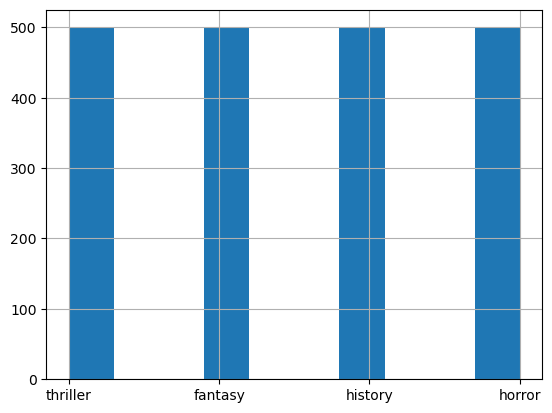

In [3]:
df_filtered_books["genre_name"].hist()

### Decimális szám kódolású cimkék előállítása az egyes osztályokhoz

,description,genre,genre_name
2500,"The book begins where Roses are Red ended, wit...",0,thriller
2501,After proposing to his childhood sweetheart Be...,0,thriller
2502,"When a beloved former First Lady dies, an elab...",0,thriller
2503,Mississippi attorneys Wes and Mary Grace Payto...,0,thriller
2504,The story starts with Jack's fall from the Ver...,0,thriller
...,...,...,...
2495,While at the theater for a Star Trek marathon ...,3,horror
2496,"The novel centers on a group of young women, b...",3,horror
2497,Teenager Janice Crogan finds a diary belonging...,3,horror
2498,Harvest Home is narrated in the first person b...,3,horror


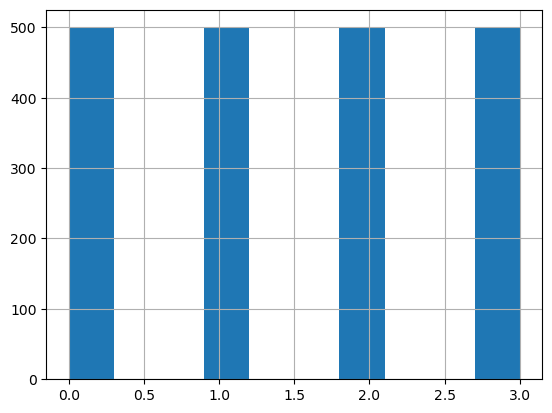

In [28]:
genre = []
for item in df_filtered_books["genre_name"].values:
    if item == "thriller":
        genre.append(0)
    elif item == "fantasy":
        genre.append(1)
    elif item == "history":
        genre.append(2)
    elif item == "horror":
        genre.append(3)
    else:
        genre.append(0)

df_filtered_books["genre"] = genre

df_filtered_books["genre"].hist()
df_filtered_books

### Az adatok train, validációs és teszt adathalmazra való bontása

In [5]:
len_df_filtered_books = len(df_filtered_books)

len_books_train = int(round(len_df_filtered_books * 0.6))
len_books_val_test = (len_df_filtered_books - len_books_train) // 8
len_books_train = len_books_train // 4

len_df_filtered_books, len_books_train, len_books_val_test

(2000, 300, 100)

In [6]:
df_books_filtered_0 = df_filtered_books.loc[df_filtered_books['genre'] == 0].copy()
df_books_filtered_1 = df_filtered_books.loc[df_filtered_books['genre'] == 1].copy()
df_books_filtered_2 = df_filtered_books.loc[df_filtered_books['genre'] == 2].copy()
df_books_filtered_3 = df_filtered_books.loc[df_filtered_books['genre'] == 3].copy()

df_books_filtered_0_train = df_books_filtered_0[:len_books_train].copy()
df_books_filtered_1_train = df_books_filtered_1[:len_books_train].copy()
df_books_filtered_2_train = df_books_filtered_2[:len_books_train].copy()
df_books_filtered_3_train = df_books_filtered_3[:len_books_train].copy()

df_books_filtered_0_val = df_books_filtered_0[len_books_train:len_books_train+len_books_val_test].copy()
df_books_filtered_1_val = df_books_filtered_1[len_books_train:len_books_train+len_books_val_test].copy()
df_books_filtered_2_val = df_books_filtered_2[len_books_train:len_books_train+len_books_val_test].copy()
df_books_filtered_3_val = df_books_filtered_3[len_books_train:len_books_train+len_books_val_test].copy()

df_books_filtered_0_test = df_books_filtered_0[len_books_train+len_books_val_test:].copy()
df_books_filtered_1_test = df_books_filtered_1[len_books_train+len_books_val_test:].copy()
df_books_filtered_2_test = df_books_filtered_2[len_books_train+len_books_val_test:].copy()
df_books_filtered_3_test = df_books_filtered_3[len_books_train+len_books_val_test:].copy()

### Az előállított tanuló, validációs és teszt adathalmazok ellenőrzése

Az ellenőrzés során jól látható, hogy a nyers adathalmaz felbontása tanuló, validációs és teszt adathalmazon olyan módon történt hogy a létrejövő adathalmazokban az adatok osztályok szerinti egyeneletes eloszlása megmaradt.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 5 to 2750
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  1200 non-null   object
 1   genre        1200 non-null   int64 
 2   genre_name   1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.5+ KB


array([[<AxesSubplot:title={'center':'genre'}>]], dtype=object)

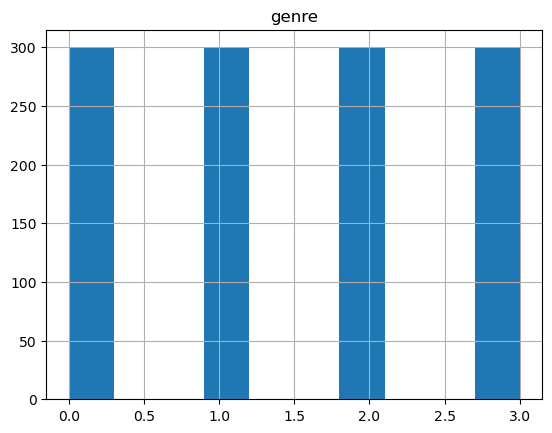

In [7]:
df_books_filtered_train = pd.concat([df_books_filtered_0_train, 
                                    df_books_filtered_1_train, 
                                    df_books_filtered_2_train,
                                    df_books_filtered_3_train])
df_books_filtered_train = df_books_filtered_train.sample(frac=1)
df_books_filtered_train.info()
df_books_filtered_train.hist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 2854 to 2396
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  400 non-null    object
 1   genre        400 non-null    int64 
 2   genre_name   400 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.5+ KB


array([[<AxesSubplot:title={'center':'genre'}>]], dtype=object)

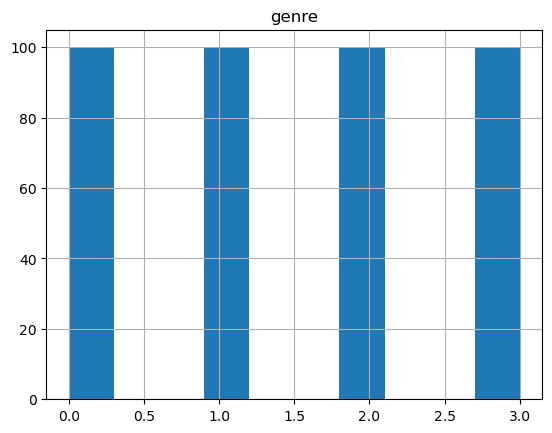

In [8]:
df_books_filtered_val = pd.concat([df_books_filtered_0_val, 
                                    df_books_filtered_1_val, 
                                    df_books_filtered_2_val,
                                    df_books_filtered_3_val])
df_books_filtered_val = df_books_filtered_val.sample(frac=1)
df_books_filtered_val.info()
df_books_filtered_val.hist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1923 to 2493
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  400 non-null    object
 1   genre        400 non-null    int64 
 2   genre_name   400 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.5+ KB


array([[<AxesSubplot:title={'center':'genre'}>]], dtype=object)

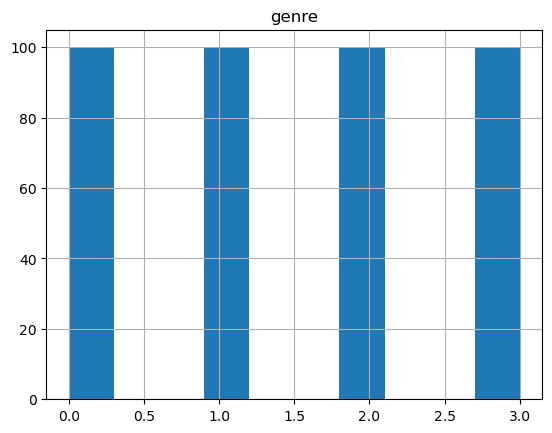

In [9]:
df_books_filtered_test = pd.concat([df_books_filtered_0_test, 
                                    df_books_filtered_1_test, 
                                    df_books_filtered_2_test,
                                    df_books_filtered_3_test])
df_books_filtered_test = df_books_filtered_test.sample(frac=1)
df_books_filtered_test.info()
df_books_filtered_test.hist()

### Elkészített és ellenőrzött adathalmazok kiírása

In [10]:
books_train = "data/books_train.json"
df_books_filtered_train.to_json(books_train, orient="records")
df_readed_books_filtered_train = pd.read_json(books_train, orient='records')

books_val = "data/books_val.json"
df_books_filtered_val.to_json(books_val, orient="records")
df_readed_books_filtered_val = pd.read_json(books_val, orient='records')

books_test = "data/books_test.json"
df_books_filtered_test.to_json(books_test, orient="records")

## Tanuló, validációs és teszt adatok beolvasása

In [11]:
df_train = pd.read_json("data/books_train.json", orient="records")
df_val = pd.read_json("data/books_val.json", orient="records")
df_test = pd.read_json("data/books_test.json", orient="records")

# Adatok megtisztítása

A jobb eredmény elérése érdekében az adatokból eltávolításra kerülnek a speciális html és egyéb karakterek és stopwordok. A szövegek minden karakter kisbetűre lesz alakítva továbbá egyszerű szavankénti tokenizálással fel lesz darabolva.

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

STOPWORDS = stopwords.words("english")

def is_html_tag(word):
    w = word.replace("\n", "")
    return w.startswith("<") or w.startswith(">") or w.startswith("/") or w.strip()[:2] == "br"

def remove_html_tags(sentence):
    single_spaces = " ".join(sentence.split())

    return " ".join([token for token in single_spaces.split(" ") if not is_html_tag(token)])

def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split(" ") if not word in STOPWORDS])

def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word.isalpha()]

def preprocess(sentence):
    return remove_punctuation(tokenize_sentence(remove_stopwords(remove_html_tags(str(sentence)))))


In [13]:
df_train["description"] = df_train["description"].apply(preprocess)
df_train

,description,genre,genre_name
0,"[the, novel, concerns, dwelling, darkovan, ord...",1,fantasy
1,"[an, amoral, doctor, forever, changes, lives, ...",0,thriller
2,"[santiago, cruz, kekchi, campesinos, indigenos...",2,history
3,"[promising, final, year, novice, kyarra, disap...",1,fantasy
4,"[the, book, begins, roses, red, ended, alex, c...",0,thriller
...,...,...,...
1195,"[ruby, school, life, immediately, gets, bad, s...",3,horror
1196,"[after, returning, home, strange, things, star...",1,fantasy
1197,"[the, book, divided, four, sections, organized...",2,history
1198,"[among, us, live, others, they, humans, enter,...",3,horror


## Szótár építése a tokenizált szövegből. 

Erre azért van szükség hogy megtudjuk határozni a szöveg szókészletét és ez alapján a gyakorisági táblázatot elő tudjuk állítani.

In [14]:
def build_vocab(tokenized_input, vocab_size):
    d = dict()

    for tokens in tokenized_input:
        for token in tokens:
            # double check
            if token not in STOPWORDS and token.isalpha():
                d[token] = d.get(token, 0) + 1


    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:vocab_size]}

In [15]:
VOCAB_SIZE = 10000
VOCAB = build_vocab(df_train["description"].values, VOCAB_SIZE) 
len(VOCAB)

10000

## Tanuló címkék előállítása és leképzése

In [16]:
GENRES = df_train["genre"].unique()
GENRES

array([1, 0, 2, 3], dtype=int64)

In [17]:
GENRES_TO_NAMES = {genre: df_train[df_train["genre"] == genre].iloc[0]["genre_name"] for genre in GENRES}
GENRES_TO_NAMES

{1: 'fantasy', 0: 'thriller', 2: 'history', 3: 'horror'}

## Szavak gyakorsiágának meghatározása

In [18]:
def get_frequencies_for_genres(df):
    dict_freqs = {genre: {} for genre in GENRES}

    for idx in range(df.shape[0]):
        tokens = df.iloc[idx, 0]
        genre = df.iloc[idx, 1]
        
        for token in set(tokens):
            if token in VOCAB:
                dict_freqs[genre][token] = dict_freqs[genre].get(token, 0) + 1
            

    return dict_freqs

frequency_table = get_frequencies_for_genres(df_train)

# A book szó gyakroisága az egyes osztályokban
'thriller', frequency_table[0]["book"], 'fantasy', frequency_table[1]["book"], 'history', frequency_table[2]["book"], 'horror', frequency_table[3]["book"]

('thriller', 91, 'fantasy', 102, 'history', 86, 'horror', 95)

## Tanuló jellemzők és címkék elkészítése

Minden egyes tanuló mintához meghatározásra kerül, hogy a benne lévő szavak milyen gyakorisággal vesznek részt az egyes osztályokban. Ezáltal minden egyes szöveghez leképezhető egy elem négyesre. Ezekhez fogja az optimális súlyokat megkeresni a logisztikus model

In [19]:
import numpy as np

def extract_features(frequency_table, tweet_tokens):
    genre_frequencies = {genre: 0 for genre in GENRES}

    for t in tweet_tokens:
        for genre in GENRES:
            genre_frequencies[genre] += frequency_table[genre].get(t, 0)
    
    return pd.Series(genre_frequencies)


In [20]:
X_train_logistic = df_train["description"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_train_logistic

,1,0,2,3
0,573,490,656,669
1,420,345,346,406
2,5922,4560,5749,5511
3,16633,11840,14121,15148
4,43292,44330,41685,49716
...,...,...,...,...
1195,8383,6867,8324,9122
1196,1261,923,1128,1396
1197,1455,1245,1535,1429
1198,22949,16843,18352,23031


In [21]:
y_train_logistic = df_train["genre"].values
y_train_logistic

array([1, 0, 2, ..., 2, 3, 0], dtype=int64)

## Logisztikus model alkalmazása

### Validációs adathalmaz előkészítése az optimális modell megtalálásához

In [22]:
X_val = df_val["description"].apply(preprocess)
X_val_logistic = df_val["description"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_val_logistic = df_val["genre"].values
X_val_logistic

,1,0,2,3
0,54,905,171,412
1,24,246,42,122
2,23,319,61,143
3,12,38,12,20
4,4,70,16,30
...,...,...,...,...
395,306,3373,529,1644
396,43,407,57,208
397,46,840,158,376
398,4,91,19,40


### Tanítás és validáció

In [27]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.linear_model import LogisticRegression

results = { "iter" : [], "Train accuracy" : [], "Validation accuracy" : []}
X_val = df_val["description"].apply(preprocess)

for max_iter in tqdm([2, 3, 4, 5, 10, 15]):
    clf = LogisticRegression(random_state=0, max_iter=max_iter, solver="newton-cg").fit(X_train_logistic, y_train_logistic)
    
    preds_train = clf.predict(X_train_logistic)
    preds_val = clf.predict(X_val_logistic)

    results["iter"].append(max_iter)
    results["Train accuracy"].append(accuracy_score(y_train_logistic, preds_train))
    results["Validation accuracy"].append(accuracy_score(y_val_logistic, preds_val))

results = pd.DataFrame(results)
results

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.33it/s]


,iter,Train accuracy,Validation accuracy
0,2,0.830833,0.2500
1,3,0.835000,0.2500
2,4,0.839167,0.2500
3,5,0.838333,0.2500
4,10,0.839167,0.2500
5,15,0.844167,0.2525


In [24]:
best_iter = results["iter"].values[np.argmax(results["Validation accuracy"].values, axis=0)]
best_iter

15

### Test adathalmaz előkészítése

In [25]:
X_test = df_test["description"].apply(preprocess)
X_test_logistic = df_test["description"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_test_logistic = df_test["genre"].values
X_test_logistic

,1,0,2,3
0,70,1340,240,607
1,211,2120,396,1011
2,186,2074,388,996
3,201,2270,518,1017
4,11,82,16,41
...,...,...,...,...
395,37,558,102,257
396,115,1196,190,593
397,41,666,118,304
398,95,815,135,400


### A legjobb modell tesztelése

In [26]:
clf = LogisticRegression(random_state=0, max_iter=best_iter, solver="newton-cg").fit(X_train_logistic, y_train_logistic)

preds_test = clf.predict(X_test_logistic)

print("Test accuracy:", accuracy_score(y_test_logistic, preds_test))

Test accuracy: 0.2475
